In [38]:
from operator import mod
import sys
#function that installs packages
def install(package):
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])



try:
    import pandas as pd
    from pandas import datetime
    from datetime import timedelta
    import numpy as np
    import matplotlib.pyplot as plt
    from pandas.plotting import register_matplotlib_converters
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.arima.model import ARIMA
    register_matplotlib_converters()
    from time import time

    import warnings
    warnings.filterwarnings("ignore")
except ImportError as e:
    #install the required packages
    #get the module name first
    module_name = e.name
    #install the module
    install(module_name)


# Ice Cream Production Data
In the following task we try to forecast ice cream production data with an AR Model.

In [39]:
# read and inspect data
df = pd.read_csv('ice_cream.csv')
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [40]:
# let's rename the columns
df.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

In [41]:
# convert date column to datetime type
df['date'] = pd.to_datetime(df.date)

# set date as index
df.set_index('date', inplace=True)

Now it's your turn. Follow the instructions in the comments to prepare your Dataframe.

In [42]:
# just get data from 2010 onwards
# hint: now as your index is a datetime type, you can use a datetime variable to access the index
df_2010 = df.loc['2010-01-01':]


Text(0.5, 1.0, 'Ice Cream Production')

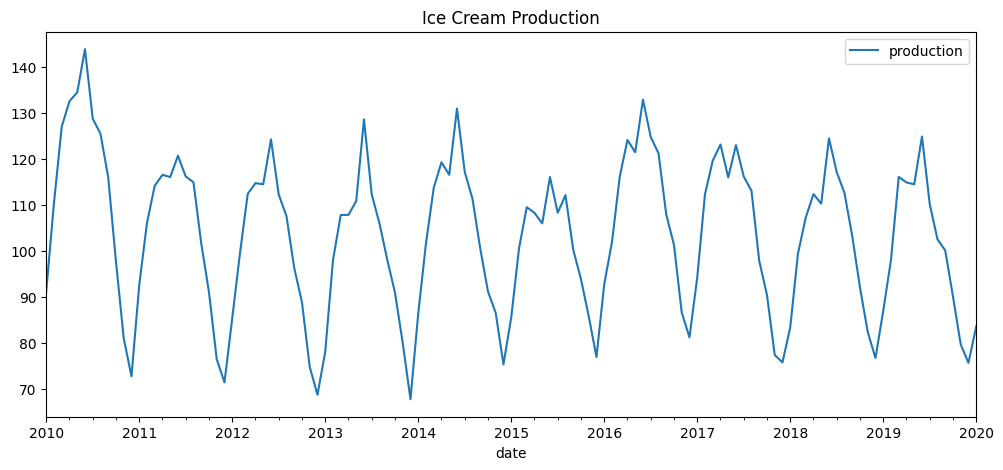

In [43]:
# plot the ice cream data
fig = df_2010.plot(figsize=(12,5))
fig.set_title('Ice Cream Production')


# Autocorrelation Function (ACF)
Now we will inspect our data with the autocorrelation function.

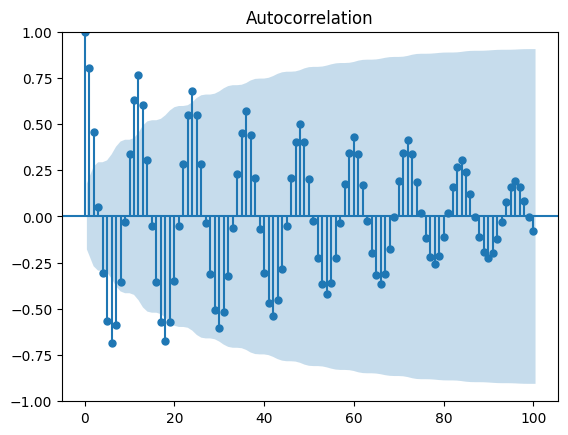

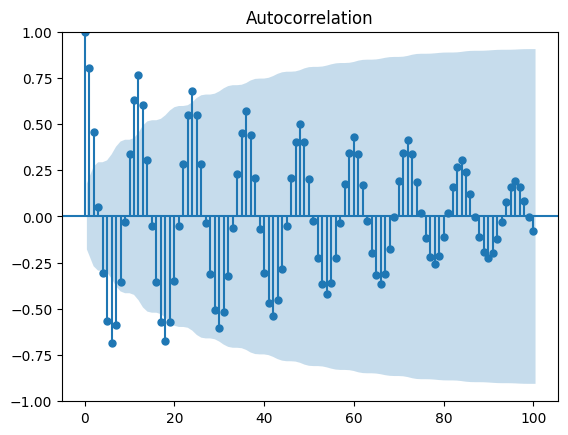

In [44]:
# use the acf plot to inspect your data, use 100 lags
# hint: see plot_acf()
plot_acf(df_2010, lags=100)

> Conclusion: <br> Based on decaying ACF, we are likely dealing with an Auto Regressive process.

# Partial Autocorrelation Function (PACF)
Let's inspect our data with the PACF to control for other lags so that we can decide which lags to use in our AR Model.

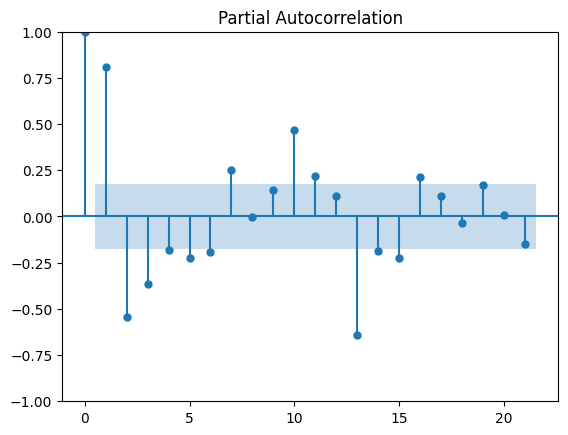

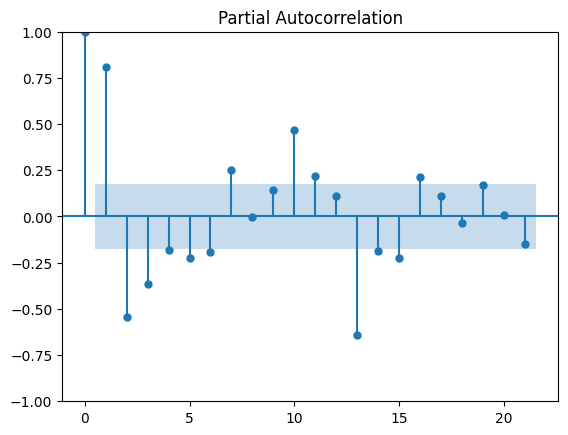

In [45]:
# plot the pacf
# hint: see plot_pacf()
plot_pacf(df_2010)

> Conclusion: <br> Based on PACF, we should start with an Auto Regressive model with lags 1, 2, 3, 10, 13.

# Autoregressive Model
To build and evaluate our AR Model we need to devide the data in a training and testing set. 

In [46]:
# set dates of training and testing set
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

# now create your sets with the given dates
def create_df_time(df_data, train_end, test_end):
    train = df_data.loc[:train_end]
    test = df_data.loc[train_end+timedelta(days=1):test_end]
    return train, test
df_2010_train, df_2010_test = create_df_time(df_2010, train_end, test_end)



In [47]:
# to fit the AR Model we use ARIMA without differences and moving average
# research ARIMA from statsmodels
# use the order (p,d,q)
# fit the model with the first 3 lags

arima_model = ARIMA(df_2010_train, order=(3,0,0))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Fri, 04 Nov 2022   AIC                            758.170
Time:                        11:22:21   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

In [48]:
# get the start and end dates of the prediction dataframe
test_start_date = df_2010_test.index[0]
test_end_date = df_2010_test.index[-1]


In [49]:
# get the predictions and residuals from your AR Model
df_2010_predict = arima_model_fit.predict(start=test_start_date, end=test_end_date)

Text(0, 0.5, 'Error')

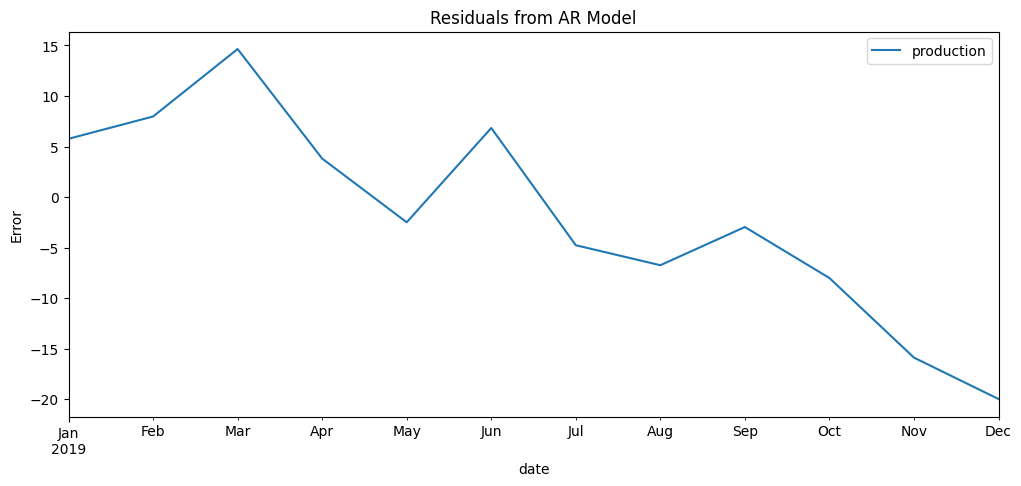

In [50]:
# plot the residuals as you can see below
# don't forget to add a horizontal line at 0 and a vertical line at the start date
df_2010_error = df_2010_test.sub(df_2010_predict, axis=0)
fig = df_2010_error.plot(figsize=(12,5))
fig.set_title('Residuals from AR Model')
#name y axis
fig.set_ylabel('Error')



<AxesSubplot: xlabel='date'>

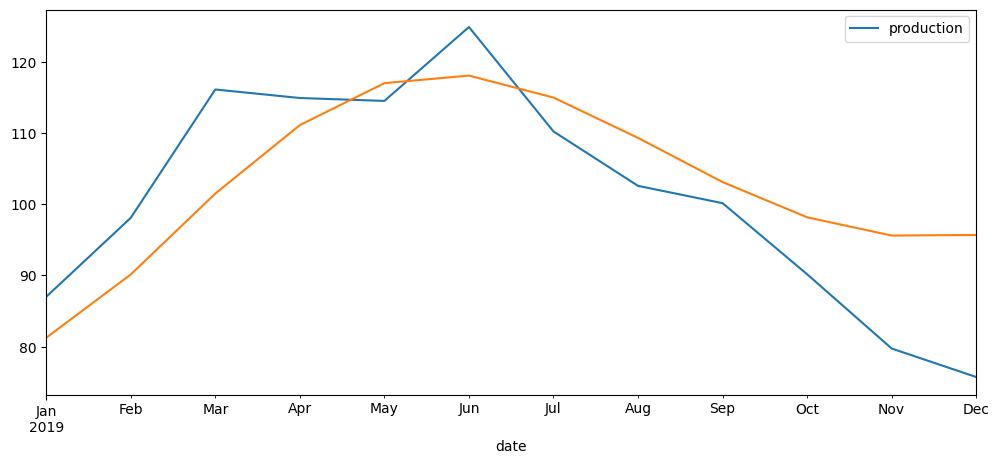

In [58]:
# compare the actual data with your predictions over time as you see below

df_2010_test.plot(figsize=(12,5))
df_2010_predict.plot()


In [56]:
# last but not least, we should look at
# 1. Mean Absolute Percentage Error
# 2. Root Mean Square Error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

mape = mean_absolute_percentage_error(df_2010_test, df_2010_predict)
mse = mean_squared_error(df_2010_test, df_2010_predict)

print("The Mean Absolute Percentage Error is: ", mape)
print("The Root Mean Square Error is: ", mse)



The Mean Absolute Percentage Error is:  0.08951274993668519
The Root Mean Square Error is:  97.6965941461691
